Loading required package: limma
Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, tab

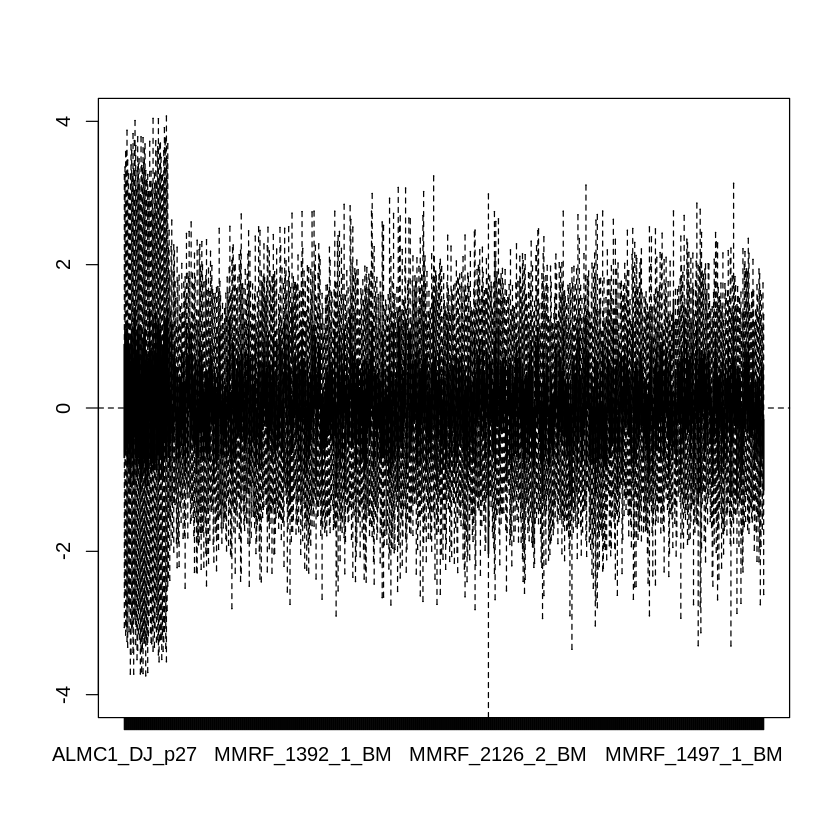

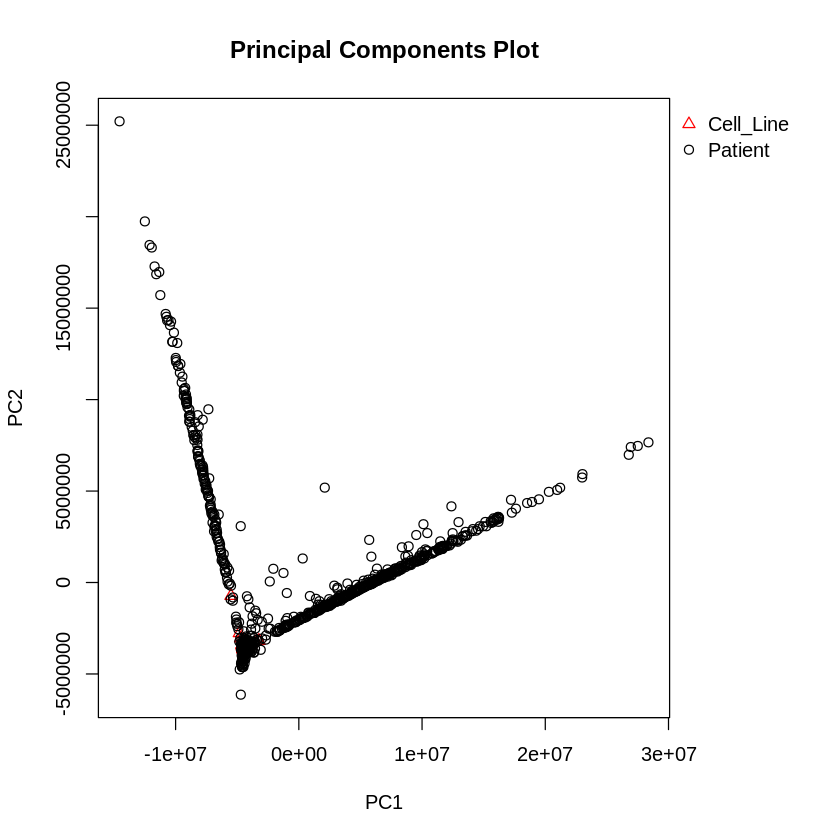

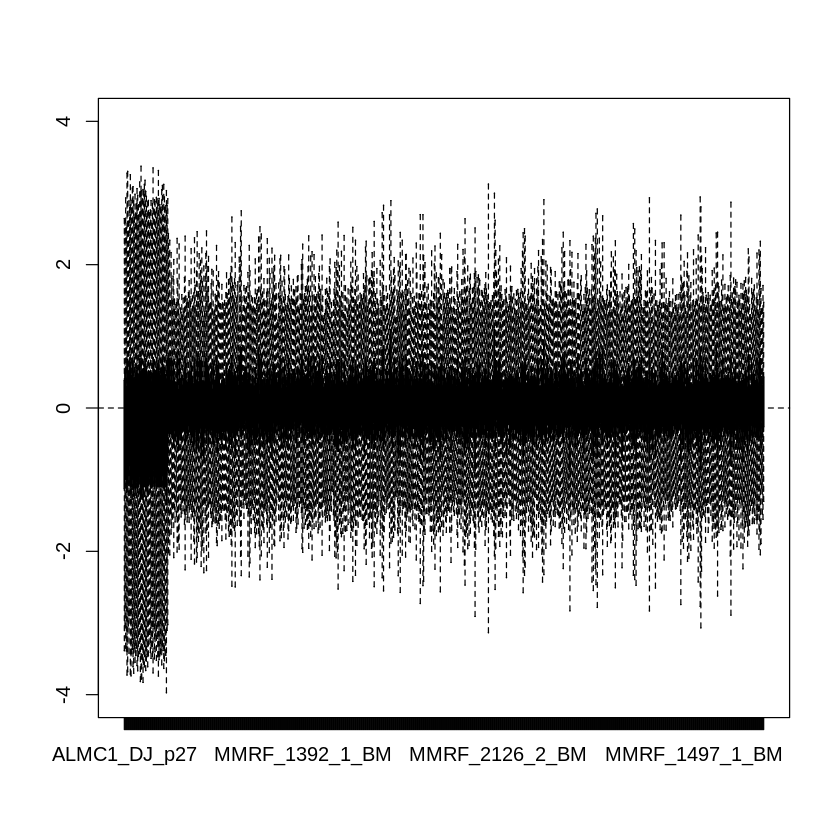

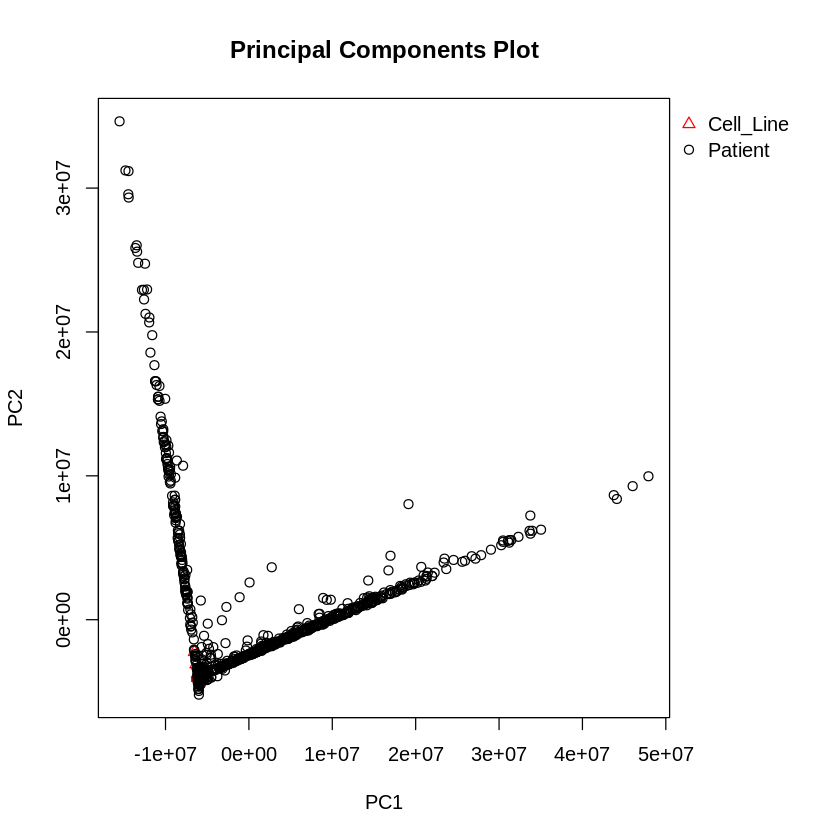

In [1]:
setwd('~/Downloads/proj/')

library(data.table)
library(edgeR)
library(EDASeq)
library(RUVSeq)
library(affycoretools)
library(ggplot2)

#project directories, and libraries loaded

MM_cell_line = data.frame(fread("HMCL66_HTSeq_GENE_Counts_v2.txt"))
MM_patients = data.frame(fread("MMRF_CoMMpass_IA13a_E74GTF_HtSeq_Gene_Counts.txt"))

#reading and creating data frames from gene count data

ensembl_intersect = intersect(MM_cell_line$Sample, MM_patients$GENE_ID)

#finding genes in common and creating character vector of Ensembl Gene IDs

rownames(MM_cell_line) = MM_cell_line$Sample
rownames(MM_patients) = MM_patients$GENE_ID

#assigning rownames as ensembl gene IDs so as to be able to parse by ensembl Gene IDs

MM_cell_line = MM_cell_line[ensembl_intersect, -1]
MM_patients = MM_patients[ensembl_intersect, -1]
MM_combined = cbind(MM_cell_line, MM_patients)

#filtering MM_cell_line and MM_patients to only those genes in common and taking out 
    #Gene name and ensembl ID columns, then combining them

MM_cell_line_cpm = cpm(MM_cell_line[,-1])
MM_patients_cpm = cpm(MM_patients)

#getting counts per million for MM_cell_line, and MM_patients_cpm

keep = rowSums(cpm(MM_combined[-1]) > 1) > 2
MM_combined.filtered = MM_combined[keep, ]

#initial filtering of MM_combined to remove low count genes (genes with greater than 
    #1 million counts in more than 2 samples are kept)

MM_gene_names = MM_combined.filtered[, 1]
MM_combined.filtered = MM_combined.filtered[, -1]

#grabbing first colunmn of MM_combined.filtered (Gene_name), only those rows specified by ensembl intersect, 
    #for getting HK genes, removing Gene_name column from MM_combined.filtered

HK = read.table('RUVseq_HK_genes.txt')

#getting house keeping gene names

genes_to_keep = MM_gene_names %in% HK[, 'V1']

#creating boolean vector indicating which genes that are in common between MM_cell_line and MM_patients datasets 
    #are also present in housekeeping genes list, to be used for getting ensembl gene IDs for RUVseq normalization
    #by a priori known house keeping genes

HK_final = rownames(MM_combined.filtered)[genes_to_keep]

#final character vector of housekeeping genes to be used for RUVseq normalization

combined_annot = data.frame(colnames(MM_combined.filtered))
combined_annot$type = "Patient"
combined_annot$type[1:ncol(MM_cell_line[-1])] = "Cell_Line"
rn = combined_annot[,1]
combined_annot = combined_annot[-1]
rownames(combined_annot) = rn
set = newSeqExpressionSet(as.matrix(round(MM_combined.filtered)), 
                          phenoData = combined_annot)
set = betweenLaneNormalization(set, which="upper")

#created new dataframe of column names of MM_combined.filtered (cell line names / patient sample IDs)
    #combined_annot and added type column to denote whether item is patient or cell line
    #then removed the column with sample names and assign as row names
    #then created a Seqexpressionset object 'set', which has the phenodata appended 
    #then normalized by the TMM uppqer quartile method

symbols = c(rep(2, ncol(MM_cell_line[-1])), rep(1, ncol(MM_patients)))

#creating numeric vectors to pass into plotPCA functions to denote sample plotting symbol and color

plotRLE(counts(set), outline=FALSE, ylim=c(-4, 4))
affycoretools::plotPCA(counts(set), groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

#plotting RLE and PCA for raw gene counts

plotRLE(normCounts(set), outline=FALSE, ylim=c(-4, 4))
affycoretools::plotPCA(normCounts(set), groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

#plotting RLE and PCA for normalied (TMM, upper quartile method) gene counts



#setest = calcNormFactors(MM_combined.filtered, method = "TMM")

#plotRLE(setest, outline=FALSE, ylim=c(-4, 4))
#affycoretools::plotPCA(setest, groupnames = c('Cell_Line', 'Patient'), 
 #                      pch = symbols, col = symbols, outside = TRUE)


converting counts to integer mode
Warning message in validityMethod(object):
"'counts' contains non-integer numbers"Warning message in plot.window(...):
""k" is not a graphical parameter"Warning message in plot.window(...):
""labels" is not a graphical parameter"Warning message in plot.window(...):
""isLog" is not a graphical parameter"Warning message in plot.xy(xy, type, ...):
""k" is not a graphical parameter"Warning message in plot.xy(xy, type, ...):
""labels" is not a graphical parameter"Warning message in plot.xy(xy, type, ...):
""isLog" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""k" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""isLog" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""k" is not a graphical parameter"Warning message in axis(side = side, at = at, labels = labels, ...):
""isLog" is not a graphical parameter"Wa

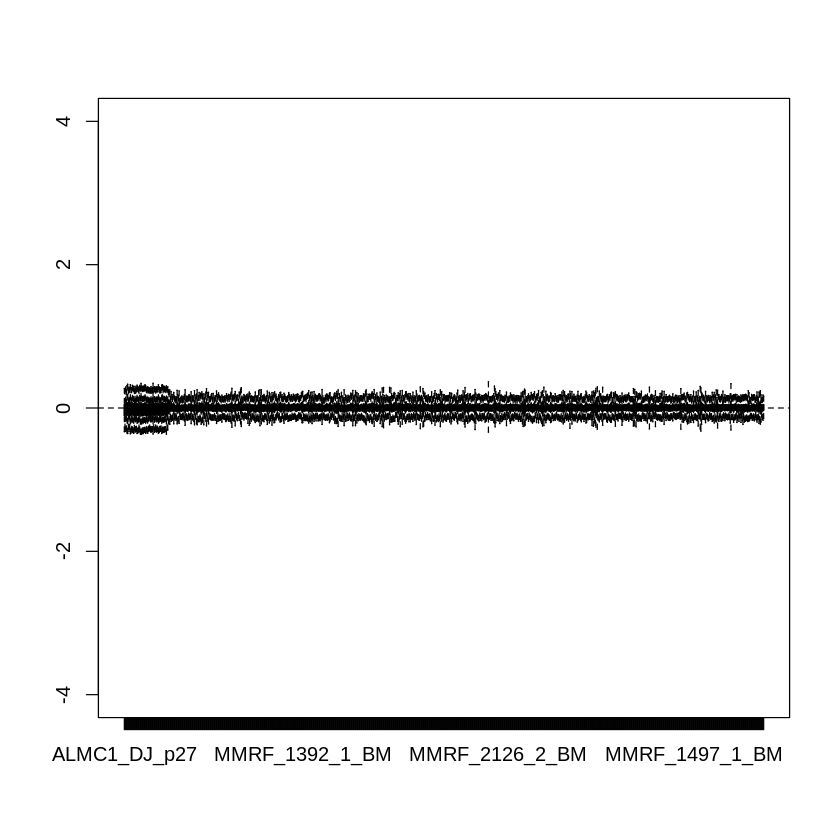

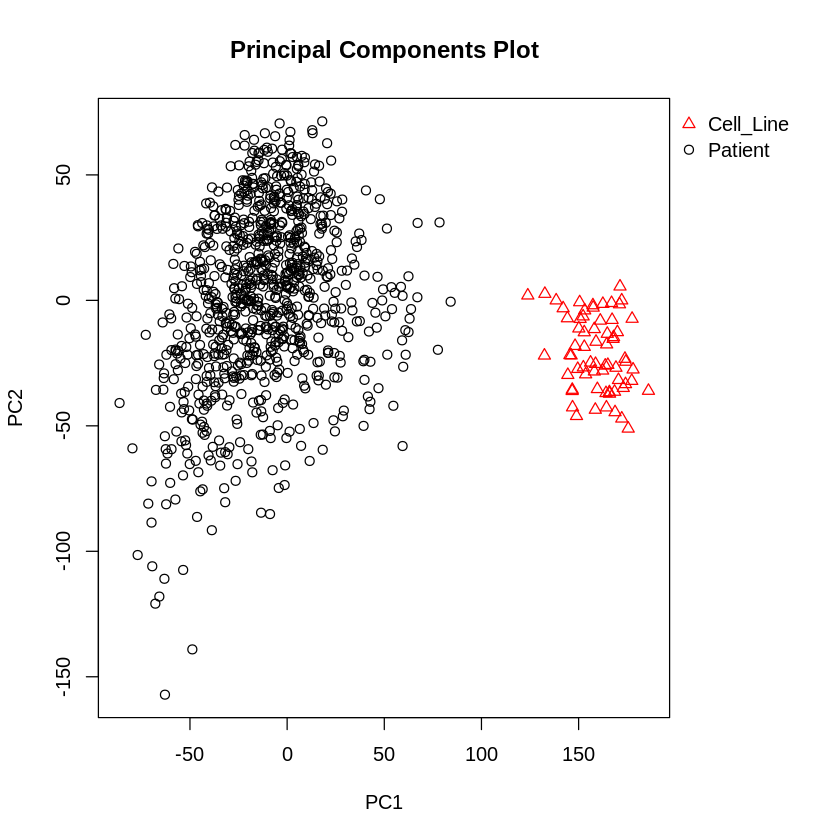

In [2]:
library(DESeq2)

setv = vst(as.matrix(round(MM_combined.filtered)))
setv = newSeqExpressionSet(setv, phenoData = combined_annot)

plotRLE(setv, outline=FALSE, ylim=c(-4, 4))
affycoretools::plotPCA(setv, groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

                              patient              sample       cor
ALMC1_DJ_p27           MMRF_2801_1_BM        ALMC1_DJ_p27 0.8025337
ALMC2_DJ_p11           MMRF_2801_1_BM        ALMC2_DJ_p11 0.7991563
AMO1_DSMZ_p8           MMRF_2801_1_BM        AMO1_DSMZ_p8 0.7811380
ANBL6_DJ2_p13          MMRF_2801_1_BM       ANBL6_DJ2_p13 0.8108229
COLO677_DSMZ_p8        MMRF_2801_1_BM     COLO677_DSMZ_p8 0.7759660
Delta47_JCRB_p16       MMRF_2801_1_BM    Delta47_JCRB_p16 0.7595372
DP6_DJ_p7              MMRF_2801_1_BM           DP6_DJ_p7 0.7823537
EJM_DSMZ_p9            MMRF_2801_1_BM         EJM_DSMZ_p9 0.7845251
FLAM76_JCRB_p10        MMRF_2801_1_BM     FLAM76_JCRB_p10 0.7896071
FR4_p6                 MMRF_2801_1_BM              FR4_p6 0.7412245
H1112_p5               MMRF_2801_1_BM            H1112_p5 0.7902986
INA6_p5                MMRF_2801_1_BM             INA6_p5 0.7882590
JIM1_ECACC_p11         MMRF_2801_1_BM      JIM1_ECACC_p11 0.7616638
JIM3_ECACC_p10         MMRF_2801_1_BM      JIM3_

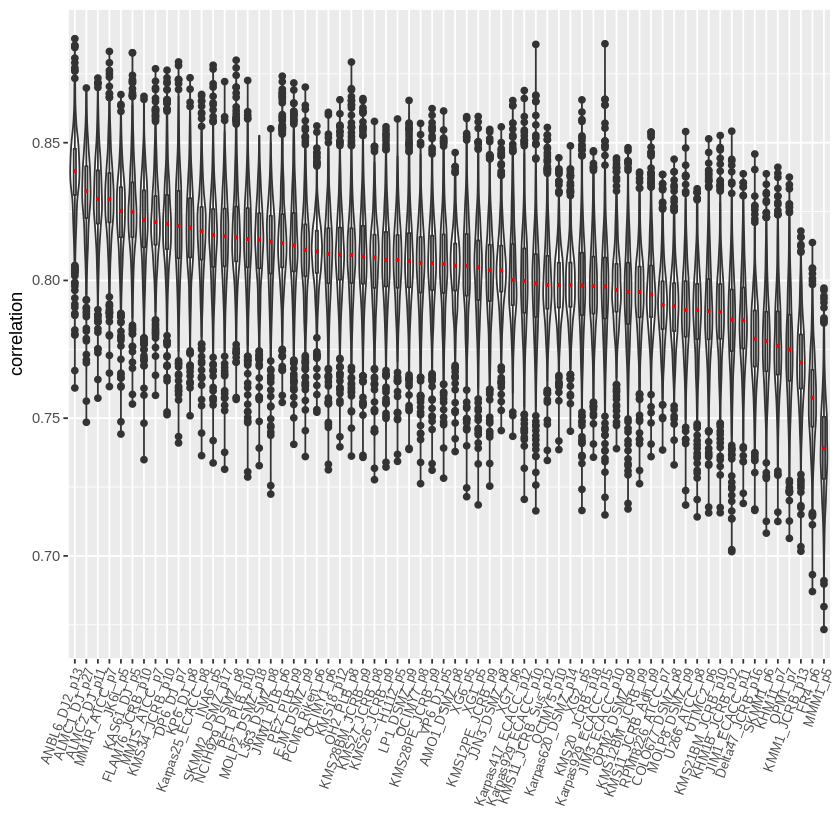

In [3]:
MM.cor.v = cor(counts(setv), method = "s")

clnames = colnames(MM_cell_line[-1])
pnames = colnames(MM_patients)
tumor_cell_all = data.frame()
#rownames(tumor_cell_all) = rep(clnames, length(pnames)) #clnames*(length(pnames))

for(patients in pnames){
    cell_line_tumor_cor = MM.cor.v[patients, clnames]
    cell_line_tumor_cor = data.frame(patient = patients, sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
    tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
}
#rownames(tumor_cell_all) = rep(clnames, length(pnames))
print(tumor_cell_all)

cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

  p <- ggplot(tumor_cell_all, aes(sample, cor))
  print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + 
          xlab("") +
          stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  theme(panel.background = element_rect(color = 'white'), axis.text.x = element_text(angle = 70, hjust = 1, size=8)) 
  )

In [ ]:
library(DESeq2)

setr = rlog(as.matrix(round(MM_combined.filtered)))
setr = newSeqExpressionSet(setr, phenoData = combined_annot)

plotRLE(setr, outline=FALSE, ylim=c(-4, 4))
affycoretools::plotPCA(normCounts(set), groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)


rlog() may take a long time with 50 or more samples,
vst() is a much faster transformation
converting counts to integer mode


In [ ]:
#setest = calcNormFactors(MM_combined.filtered, method = "TMM")
#dim(setest)
#set = newSeqExpressionSet(as.matrix(round(setest)), 
 #                         phenoData = combined_annot)
#plotRLE(setest, outline=FALSE, ylim=c(-4, 4))
#affycoretools::plotPCA(setest, groupnames = c('Cell_Line', 'Patient'), 
 #                      pch = symbols, col = symbols, outside = TRUE)


In [ ]:
affycoretools::plotPCA(log2(counts(set)+1), groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

setk1 = RUVg(set, HK_final, k=1)

plotRLE(normCounts(setk1), outline=FALSE, ylim=c(-4, 4))
affycoretools::plotPCA(log2(normCounts(setk1)+1), groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

In [ ]:
setk6 = RUVg(set, HK_final, k=6)

plotRLE(normCounts(setk6), outline=FALSE, ylim=c(-4, 4))
affycoretools::plotPCA(normCounts(setk6), groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

In [ ]:
MM.cor.k1 = cor(normCounts(setk1), method = "s")

MM.cor.k6 = cor(normCounts(setk6), method = "s")

print(MM.cor.k1)

#k1, k6 cor done w/ RLE and PCA plots as well

In [ ]:
clnames = colnames(MM_cell_line[-1])
pnames = colnames(MM_patients)
tumor_cell_all = data.frame()
#rownames(tumor_cell_all) = rep(clnames, length(pnames)) #clnames*(length(pnames))

for(patients in pnames){
    cell_line_tumor_cor = MM.cor.k1[patients, clnames]
    cell_line_tumor_cor = data.frame(patient = patients, sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
    tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
}
#rownames(tumor_cell_all) = rep(clnames, length(pnames))
print(tumor_cell_all)

In [ ]:
cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

In [ ]:
  p <- ggplot(tumor_cell_all, aes(sample, cor))
  print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + 
          xlab("") +
          stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  theme(panel.background = element_rect(color = 'white'), axis.text.x = element_text(angle = 70, hjust = 1, size=8)) 
  )

In [ ]:
clnames = colnames(MM_cell_line[-1])
pnames = colnames(MM_patients)
tumor_cell_all = data.frame()
#rownames(tumor_cell_all) = rep(clnames, length(pnames)) #clnames*(length(pnames))

for(patients in pnames){
    cell_line_tumor_cor = MM.cor.k6[patients, clnames]
    cell_line_tumor_cor = data.frame(patient = patients, sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
    tumor_cell_all = rbind(tumor_cell_all, cell_line_tumor_cor)
}
#rownames(tumor_cell_all) = rep(clnames, length(pnames))
print(tumor_cell_all)

cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

  p <- ggplot(tumor_cell_all, aes(sample, cor))
  print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + 
          xlab("") +
          stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  theme(panel.background = element_rect(color = 'white'), axis.text.x = element_text(angle = 70, hjust = 1, size=8)) 
  )

In [ ]:
cell_line_order <- aggregate(cor ~ sample, tumor_cell_all, median)
cell_line_ordered <- cell_line_order$sample[order(cell_line_order$cor, decreasing=T)]
tumor_cell_all$sample = factor(tumor_cell_all$sample, levels = cell_line_ordered)

In [ ]:
head(cell_line_tumor_cor)

In [ ]:
patients = pnames[1]
cell_line_tumor_cor = MM.cor.k1[patients, clnames]
cell_line_tumor_cor = data.frame(patient = patients, sample = names(cell_line_tumor_cor), cor = cell_line_tumor_cor)
print(cell_line_tumor_cor)


In [ ]:
  p <- ggplot(cell_line_tumor_cor, aes(patient, cor))
  print(p + geom_violin()  +  ylab("correlation") + geom_boxplot(width=0.2) + 
          xlab("") +
          stat_summary(geom = "crossbar", width=0.2, fatten=2, color="red", fun.data = function(x){ return(c(y=median(x), ymin=median(x), ymax=median(x))) }) +  theme(panel.background = element_rect(color = 'white'), axis.text.x = element_text(angle = 70, hjust = 1, size=8)) 
  )

In [ ]:
library(ggplot2)

In [ ]:
x <- as.factor(combined_annot$type)
design <- model.matrix(~x, data=pData(set))
y <- DGEList(counts=counts(set), group=x)
y <- calcNormFactors(y, method="upperquartile")
y <- estimateGLMCommonDisp(y, design)
y <- estimateGLMTagwiseDisp(y, design)
fit <- glmFit(y, design)
lrt <- glmLRT(fit, coef=2)
top <- topTags(lrt, n=nrow(set))$table

In [ ]:
empiricalbot15 <- rownames(set)[which(!(rownames(set) %in% rownames(top)[1:5000]))]
ndt = as.matrix(MM_combined.filtered[empiricalbot15,])
affycoretools::plotPCA(log2(ndt+1), groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

In [ ]:
xa = length(MM_combined.filtered[,1])-1000
xb = length(MM_combined.filtered[,1])-5000

empiricalbot5 <- rownames(set)[which(!(rownames(set) %in% rownames(top)[1:xb]))]
ndt2 = as.matrix(MM_combined.filtered[empiricalbot5,])
affycoretools::plotPCA(log2(ndt2+1), groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

In [ ]:
empiricalbot1 <- rownames(set)[which(!(rownames(set) %in% rownames(top)[1:xa]))]
ndt3 = as.matrix(MM_combined.filtered[empiricalbot1,])
affycoretools::plotPCA(log2(ndt3+1), groupnames = c('Cell_Line', 'Patient'), 
                       pch = symbols, col = symbols, outside = TRUE)

In [ ]:
setk1e15 = RUVg(set, empiricalbot15, k=1)
setk6e15 = RUVg(set, empiricalbot15, k=6)
plotRLE(normCounts(setk1e15), outline=FALSE, ylim=c(-4, 4))
plotRLE(normCounts(setk6e15), outline=FALSE, ylim=c(-4, 4))

In [ ]:
setk1e5 = RUVg(set, empiricalbot5, k=1)
setk6e5 = RUVg(set, empiricalbot5, k=6)
plotRLE(normCounts(setk1e5), outline=FALSE, ylim=c(-4, 4))
plotRLE(normCounts(setk6e5), outline=FALSE, ylim=c(-4, 4))

In [ ]:
setk1e1 = RUVg(set, empiricalbot1, k=1)
setk6e1 = RUVg(set, empiricalbot1, k=6)
plotRLE(normCounts(setk1e1), outline=FALSE, ylim=c(-4, 4))
plotRLE(normCounts(setk6e1), outline=FALSE, ylim=c(-4, 4))

In [ ]:
MM_cell_line.filtered = MM_combined.filtered[,1:length(colnames(MM_cell_line[-1]))]
MM_patient.filtered = MM_combined.filtered[,-(1:length(colnames(MM_cell_line[-1])))]

setco = newSeqExpressionSet(as.matrix(round(MM_cell_line.filtered)))

setpo = newSeqExpressionSet(as.matrix(round(MM_patient.filtered)))

#x <- as.factor(combined_annot$type)
#design <- model.matrix(~x, data=pData(set))
designco = matrix(1, nrow = length(colnames(MM_cell_line.filtered)), ncol = 2)
yco <- DGEList(counts=counts(setco))
print(yco)
yco <- calcNormFactors(yco, method="upperquartile")
yco <- estimateGLMCommonDisp(yco)#, designco)#, design)
yco <- estimateGLMTagwiseDisp(yco)#, designco)#, design)
#fitco <- glmFit(yco)#, designco)#, design)
#lrtco <- glmLRT(fitco, coef=2)
#topco <- topTags(lrtco, n=nrow(setco))$table
